# 使用块的网络（VGG）

VGG块

In [1]:
import sys
sys.path.append('..')

In [2]:
from d2l import mindspore as d2l
from mindspore import nn, ops

def vgg_block(num_convs, in_channels, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels, out_channels,
                                kernel_size=3, padding=1, pad_mode='pad', weight_init='xavier_uniform'))
        layers.append(nn.ReLU())
        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.SequentialCell(layers)

VGG网络

In [3]:
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

def vgg(conv_arch):
    conv_blks = []
    in_channels = 1
    for (num_convs, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels

    return nn.SequentialCell([
        *conv_blks, nn.Flatten(),
        nn.Dense(out_channels * 7 * 7, 4096, weight_init='xavier_uniform'), nn.ReLU(), nn.Dropout(keep_prob=1-0.5),
        nn.Dense(4096, 4096, weight_init='xavier_uniform'), nn.ReLU(), nn.Dropout(keep_prob=1-0.5),
        nn.Dense(4096, 10, weight_init='xavier_uniform')])

net = vgg(conv_arch)

观察每个层输出的形状

In [4]:
X = ops.randn(1, 1, 224, 224)
for blk in net:
    X = blk(X)
    print(blk.__class__.__name__,'output shape:\t',X.shape)

SequentialCell output shape:	 (1, 64, 112, 112)
SequentialCell output shape:	 (1, 128, 56, 56)
SequentialCell output shape:	 (1, 256, 28, 28)
SequentialCell output shape:	 (1, 512, 14, 14)
SequentialCell output shape:	 (1, 512, 7, 7)
Flatten output shape:	 (1, 25088)
Dense output shape:	 (1, 4096)
ReLU output shape:	 (1, 4096)
Dropout output shape:	 (1, 4096)
Dense output shape:	 (1, 4096)
ReLU output shape:	 (1, 4096)
Dropout output shape:	 (1, 4096)
Dense output shape:	 (1, 10)


由于VGG-11比AlexNet计算量更大，因此我们构建了一个通道数较少的网络

In [5]:
ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
net = vgg(small_conv_arch)

模型训练

loss 0.166, train acc 0.972, test acc 0.918
2377.6 examples/sec


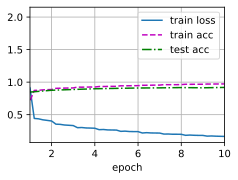

In [6]:
lr, num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr)